## Review on GAN 

GAN is a network combining the generator network $G$ and the discriminator network $D$. 

We aim to produce $G$ so that the distribution of real samples is similar to the fake ones, but there is a discriminator which can judge between the real and fake ones.

In [333]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.legacy.nn as L
import matplotlib.pyplot as plt
import numpy as np
import PIL

Dataset: $\hspace{20pt}$ cifar10 / lsun / imagenet / folder / lfw 

dataroot: $\hspace{18pt}$ path to dataset

workers: $\hspace{18pt}$ number of data loading workers

$nz$: $\hspace{37pt}$ size of the latent noisy $z$ vector 

ngf: $\hspace{34pt}$ number of generator feature 

ndf: $\hspace{34pt}$ number of discriminator feature

In [332]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', required=True, help='cifar10 | lsun | imagenet | folder | lfw ')
parser.add_argument('--dataroot', required=True, help='path to dataset')
parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
parser.add_argument('--batchSize', type=int, default=64, help='input batch size')
parser.add_argument('--imageSize', type=int, default=64, help='the height / width of the input image to network')
parser.add_argument('--nz', type=int, default=100, help='size of the latent z vector')
parser.add_argument('--ngf', type=int, default=64)
parser.add_argument('--ndf', type=int, default=64)
parser.add_argument('--niter', type=int, default=25, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
parser.add_argument('--netG', default='', help="path to netG (to continue training)")
parser.add_argument('--netD', default='', help="path to netD (to continue training)")
parser.add_argument('--outf', default='.', help='folder to output images and model checkpoints')
parser.add_argument('--manualSeed', type=int, help='manual seed')

_StoreAction(option_strings=['--manualSeed'], dest='manualSeed', nargs=None, const=None, default=None, type=<type 'int'>, choices=None, help='manual seed', metavar=None)

In [24]:
manualSeed = random.randint(1, 10000)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [316]:
def img_show(img, num_img):
    fig = plt.figure(figsize=(8,12))
    for i in range(num_img):
        a=fig.add_subplot(1, num_img , i+1)
        image = to_pil(img[i].data)
        plt.imshow(image)
        plt.axis('off')
        plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

In [317]:
def img_show_2(img, num_img):
    fig = plt.figure(figsize=(10,14))
    for i in range(num_img):
        a=fig.add_subplot(1, num_img, i+1)
        image = to_pil(img[i])
        plt.imshow(image)
        plt.axis('off')
        plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

weights initialization on Generators net $G$ and net $D$. <br />


In [27]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

### generator network G definition

The input of the generator $z$ with dim $nz$ is a noise vector. 

Then the generator is passed through sequence of deconvolutional layers.

In [33]:
class _netG(nn.Module):
    def __init__(self, ngpu):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

In [311]:
netG = _netG(ngpu)
netG.apply(weights_init)

### discriminator network D definition

A batch of fake images is passed through sequence of convolutional layers to give out a probability. <br\>
It is a binary classification problem. So the probability of the sample coming from real ones is given by $y = \frac{1}{1+\exp{x}}$.

In [312]:
class _netD(nn.Module):
    def __init__(self, ngpu):
        super(_netD, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1)

In [314]:
netD = _netD(ngpu)
netD.apply(weights_init)

Binary cross entropy is the standard loss criterion to maximum the likelihood of collect labeling. 

That is, $u=-\frac{1}{n}\sum_i [(1-\delta_i)\log(1-y_i)+(\delta_i)\log(y_i)]$,

where $\delta_i$ is the indicator function of the image $I_i$ being truly the real one.

In [315]:
criterion = nn.BCELoss()

### Training

Create (i) input $x$ of the image size, and (ii) a noise vector $z$.

In [318]:
input = torch.FloatTensor(opt.batchSize, 3, opt.imageSize, opt.imageSize)
noise = torch.FloatTensor(opt.batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(opt.batchSize, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(opt.batchSize)
real_label = 1
fake_label = 0

fixed_noise = Variable(fixed_noise)

set up the Adam optimizer with the above defined hyperparameters

In [320]:
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))

Pass the input image $x$ to the $D$ network. 

Minimize the expectation of  $ - \log(D(x)) $ in the real sample: $\mathbb{E}_{P_r}[- \log(D(x))]$

$$D_x = -\frac{1}{n}\sum_{i=1}^{n} [\log(D(x^{i})) ],$$where $n$ is the batch size.

Pass the noise vector $z$ to the $G$ network to give a fake image.

The fake image will be converted to a probability after passing through $D$ network 

Minimize the expectation of  $ - \log(1 - D(G(z)))$ in the fake sample: $$\mathbb{E}_{P_g}[- \log(1-D(G(z)))]$$

$$Error(D_{fake}) = -\frac{1}{n}\sum_{i=1}^{n} [ \log(1 - D(G(z^{i})))],$$

The loss of discriminator is given by $$Error(D) = D_x+Error(D_{fake})$$

Then backward propagation takes place.

Next the generator $G$ is trained to maximize the probability of D making a mistake.

Pass the fake image $g_z$ to the discriminator $D$ and

Minimize the expectation of  $ - \log(D(g_z))$ in the fake sample: $$\mathbb{E}_{P_r}[- \log(1-D(g_z))]$$

$$Error(G) = -\frac{1}{n}\sum_{i=1}^{n} [  \log(D(g_z^{i}))],$$
Then backward propagation takes place.

In [ ]:
for epoch in range(opt.niter):
    for i, data in enumerate(dataloader, 0):
        # train with real
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)
        if opt.cuda:
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

### Appendix: Deconvolution

Oringinal Collection of Input Images 


Suppose we have two images $I_1,I_2$ of length 4.

Denote $I_i^{j}$ the j-th channel of the image $I_i$.

In [223]:
img=Variable(torch.floor(torch.rand(2, 3, 4, 4)*255))

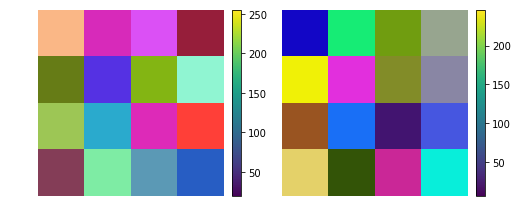

In [224]:
img_show(img, img.size(0))

Oringinal Collection of Filter Images 

Suppose now we have three filters $w_1, w_2, w_3$.

Denote $w_i^{j}$ the j-th channel of the filter $w_i$.

The image shown has zero padding before deconvolution, hence the actual size is 5.

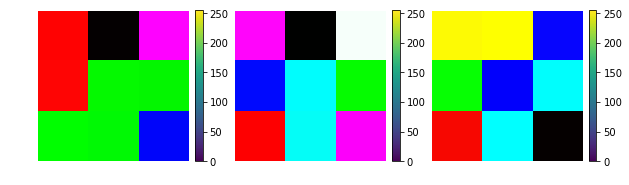

In [261]:
upsample = nn.ConvTranspose2d(3, 3, 3, stride=2, padding=1)
filters = upsample.weight.data.normal_(0.0, 0.02) 
img_show_2(filters,3)

Let $\tilde{*}$ be the deconvolution operator, and $g$ be the output. Then $$g_{i}^{j} = \sum_{t} I_{i}^{t} \hspace{3pt} \tilde{*} \hspace{3pt} w_{t}^{j}$$
Link: https://i.stack.imgur.com/YyCu2.gif

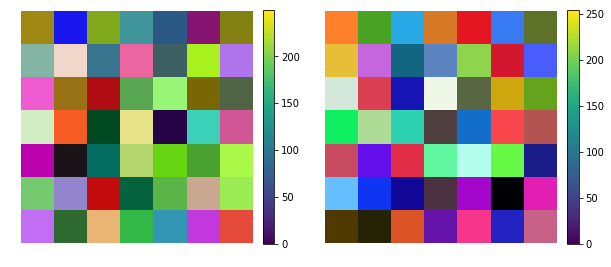

In [272]:
up_img = upsample(img)
img_show_2(up_img.data,2)